In [ ]:
# %%capture
!pip install tensorflow_text==2.6.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 7.6 MB/s 
     |████████████████████████████████| 570.3 MB 263 bytes/s 
     |████████████████████████████████| 1.3 MB 58.9 MB/s 
     |████████████████████████████████| 14.8 MB 42.7 MB/s 
     |████████████████████████████████| 132 kB 59.0 MB/s 
     |████████████████████████████████| 5.6 MB 36.0 MB/s 
     |████████████████████████████████| 462 kB 46.5 MB/s 
  Created wheel for clang: filename=clang-5.0-py3-none-any.whl size=30694 sha256=37c3119929bf359116a064530fac85dedc1ea62534f3927f5dbd885fe9adc3bb
  Stored in directory: /root/.cache/pip/wheels/98/91/04/971b4c587cf47ae952b108949b46926f426c02832d120a082a
  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4847 sha256=0773fe8ea0a05278e96bb412f777e1337c44ceb049e22c1f108b10a3e478786a
  Stored in directory: /root/.cache/pip/wheels/3f/e3/ec/8a8336ff196023622fbcb36de0c

In [ ]:
import os 
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [ ]:
from tqdm import tqdm
import numpy as np
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.express as px

from numpy import newaxis
from wordcloud import WordCloud, STOPWORDS

from tqdm import tqdm

from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

import xgboost as xgb
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, Activation, GRU, BatchNormalization
from tensorflow.keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence, text
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.optimizers import Adam

%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

plt.rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3'
use = hub.load(module_url)

In [ ]:
import pandas as pd
df_reviews = pd.read_csv("/content/final_preprocessed_nlp_data (1).csv")
df_reviews = df_reviews[["text", "sentiment"]]
df_reviews

,text,sentiment
0,last night here are some of scotts best lines ...,Positive
1,hours after her debate above any of the men ...,Positive
2,highest ratings in the history of presidential...,Positive
3,i will rescind every illegal executive action ...,Positive
4,happy when i heard she was going to be the mod...,Negative
...,...,...
10724,will never be faced with a pregnancy talk abou...,Negative
10725,expectations \n\ngopdebate imwithhuck gop cco...,Positive
10726,always tell the truth and do what i said i wou...,Positive
10727,he doesnt have time for political correctness ...,Negative


In [ ]:
def preprocess(sentiment):
  if sentiment == 'Negative':return 0
  if sentiment == 'Positive':return 1
  if sentiment == 'Neutral':return 2

df_reviews["label"] = df_reviews["sentiment"].apply(preprocess)
df_reviews

,text,sentiment,label
0,last night here are some of scotts best lines ...,Positive,1
1,hours after her debate above any of the men ...,Positive,1
2,highest ratings in the history of presidential...,Positive,1
3,i will rescind every illegal executive action ...,Positive,1
4,happy when i heard she was going to be the mod...,Negative,0
...,...,...,...
10724,will never be faced with a pregnancy talk abou...,Negative,0
10725,expectations \n\ngopdebate imwithhuck gop cco...,Positive,1
10726,always tell the truth and do what i said i wou...,Positive,1
10727,he doesnt have time for political correctness ...,Negative,0


In [ ]:
!pip install text_hammer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 115 kB 8.8 MB/s 
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray-einstats 0.2.2 requires numpy>=1.21, but you have numpy 1.19.5 which is incompatible.
tensorflow 2.6.5+zzzcolab20220523104206 requires typing-extensions<3.11,>=3.7, but you have typing-extensions 4.1.1 which is incompatible.
jax 0.3.23 requires numpy>=1.20, but you have nu

In [ ]:
import text_hammer as th

/usr/local/lib/python3.7/dist-packages/spacy/language.py:1899: UserWarning: [W123] Argument disable with value [] is used instead of ['senter'] as specified in the config. Be aware that this might affect other components in your pipeline.
  config_value=config["nlp"][key],


In [ ]:
%%time
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

def text_preprocessing(df,col_name):
    column = col_name
    df[column] = df[column].progress_apply(lambda x:str(x).lower())
    df[column] = df[column].progress_apply(lambda x: th.cont_exp(x)) #you're -> you are; i'm -> i am
    df[column] = df[column].progress_apply(lambda x: th.remove_emails(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_html_tags(x))
#     df[column] = df[column].progress_apply(lambda x: ps.remove_stopwords(x))

    df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))
#     df[column] = df[column].progress_apply(lambda x: th.make_base(x)) #ran -> run,
    return(df)

CPU times: user 2.08 ms, sys: 0 ns, total: 2.08 ms
Wall time: 3.61 ms


In [ ]:
df_cleaned = text_preprocessing(df_reviews,'text')

  0%|          | 0/10729 [00:00<?, ?it/s]

  0%|          | 0/10729 [00:00<?, ?it/s]

  0%|          | 0/10729 [00:00<?, ?it/s]

  0%|          | 0/10729 [00:00<?, ?it/s]

  0%|          | 0/10729 [00:00<?, ?it/s]

  0%|          | 0/10729 [00:00<?, ?it/s]

In [ ]:
df_reviews["label"] = df_reviews["sentiment"].apply(
    lambda x: 1 if x == 'Positive' or x == 'Neutral' else 0)

In [ ]:
df_cleaned

,text,sentiment,label
0,last night here are some of scotts best lines ...,Positive,1
1,hours after her debate above any of the men in...,Positive,1
2,highest ratings in the history of presidential...,Positive,1
3,i will rescind every illegal executive action ...,Positive,1
4,happy when i heard she was going to be the mod...,Negative,0
...,...,...,...
10724,will never be faced with a pregnancy talk abou...,Negative,0
10725,expectations gopdebate imwithhuck gop ccot tea...,Positive,1
10726,always tell the truth and do what i said i wou...,Positive,1
10727,he doesnt have time for political correctness ...,Negative,0


In [ ]:
positive_reviews = df_reviews[df_reviews.sentiment == "Positive"]
ne_reviews = df_reviews[df_reviews.sentiment == "Negative"]

In [ ]:
positive_reviews = " ".join(positive_reviews.sentiment.to_numpy().tolist())
ne_reviews = " ".join(ne_reviews.sentiment.to_numpy().tolist())

In [ ]:
label_enc = preprocessing.LabelEncoder()
encoded_review = label_enc.fit_transform(df_cleaned.sentiment.values)

In [ ]:
train_reviews, test_reviews, y_train, y_test = train_test_split(
    df_cleaned.sentiment, 
    encoded_review, 
    test_size=0.25, 
    random_state=RANDOM_SEED
  )

In [ ]:
X_train = []
for r in tqdm(train_reviews):
    emb = use(r)
    review_emb = tf.reshape(emb, [-1]).numpy()
    X_train.append(review_emb)

X_train = np.array(X_train)

100%|██████████| 8046/8046 [07:01<00:00, 19.10it/s]


In [ ]:
X_test = []
for r in tqdm(test_reviews):
    emb = use(r)
    review_emb = tf.reshape(emb, [-1]).numpy()
    X_test.append(review_emb)

X_test = np.array(X_test)

100%|██████████| 2683/2683 [02:16<00:00, 19.72it/s]


In [ ]:
print(X_train.shape, X_test.shape)

(8046, 512) (2683, 512)


In [ ]:
print(y_train.shape, y_test.shape)

(8046,) (2683,)


In [ ]:
def plot_history(history):
    accuracy = history.history['accuracy']
    val_accuracy= history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(accuracy) + 1)
    plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')

    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

    
def plot_model(model):
    model.summary()
    return tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
    layer_range=None,
    )

In [ ]:
y_train.shape

(8046,)

In [ ]:
newaxis

In [ ]:
X_train_reshaped = X_train[:, newaxis,:]
X_test_reshaped = X_test[:, newaxis,:]

In [ ]:
X_train_reshaped.shape

(8046, 1, 512)

In [ ]:
# input_shape
1,X_train_reshaped.shape[2]

(1, 512)

In [ ]:
X_train_reshaped.shape[2]

512

In [ ]:
def build_model_lstm():
    model = Sequential()
    model.add(LSTM(256, activation='relu', return_sequences=True,
                 input_shape=(1,X_train_reshaped.shape[2])))
    model.add(LSTM(128, dropout=0.2, activation='relu', return_sequences=True))
    model.add(LSTM(64, dropout=0.2, activation='relu',  return_sequences=True))
    model.add(Dense(2, activation='sigmoid'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
            metrics=['accuracy'],
            optimizer=Adam(learning_rate=0.0005))
    return model

In [ ]:
model_lstm = build_model_lstm()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 1, 256)            787456    
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 128)            197120    
_________________________________________________________________
lstm_5 (LSTM)                (None, 1, 64)             49408     
_________________________________________________________________
dense_2 (Dense)              (None, 1, 2)              130       
_________________________________________________________________
dense_3 (Dense)              (None, 1, 1)              3         
Total params: 1,034,117
Trainable params: 1,034,117
Non-trainable params: 0
_________________________________________________________________


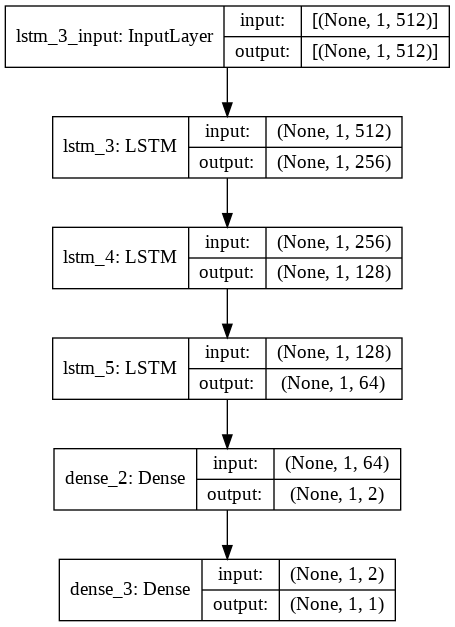

In [ ]:
plot_model(model_lstm)

In [ ]:
X_train_reshaped.shape, y_train.shape

((8046, 1, 512), (8046,))

In [ ]:
%%time
history = model_lstm.fit(
    X_train_reshaped, y_train, 
    epochs=10, 
    batch_size=16, 
    validation_split=0.1, 
    verbose=1, 
    shuffle=True
)

Epoch 1/10
453/453 [==============================] - 12s 17ms/step - loss: 0.6339 - accuracy: 0.8671 - val_loss: 0.5638 - val_accuracy: 1.0000
Epoch 2/10
453/453 [==============================] - 7s 15ms/step - loss: 0.5248 - accuracy: 1.0000 - val_loss: 0.4853 - val_accuracy: 1.0000
Epoch 3/10
453/453 [==============================] - 7s 15ms/step - loss: 0.4518 - accuracy: 1.0000 - val_loss: 0.4180 - val_accuracy: 1.0000
Epoch 4/10
453/453 [==============================] - 8s 17ms/step - loss: 0.3894 - accuracy: 1.0000 - val_loss: 0.3606 - val_accuracy: 1.0000
Epoch 5/10
453/453 [==============================] - 11s 24ms/step - loss: 0.3361 - accuracy: 1.0000 - val_loss: 0.3115 - val_accuracy: 1.0000
Epoch 6/10
453/453 [==============================] - 7s 15ms/step - loss: 0.2905 - accuracy: 1.0000 - val_loss: 0.2695 - val_accuracy: 1.0000
Epoch 7/10
453/453 [==============================] - 7s 15ms/step - loss: 0.2515 - accuracy: 1.0000 - val_loss: 0.2334 - val_accuracy: 1.00

In [ ]:
# plot_history(history)

In [ ]:
model_lstm.evaluate(X_test_reshaped, y_test)

84/84 [==============================] - 0s 5ms/step - loss: 0.1530 - accuracy: 1.0000


[0.15302573144435883, 1.0]

In [ ]:
model_lstm.save("lstm_sentiment_model4.h5")

In [ ]:
model_lstm.save("lstm_sentiment_model4")

In [ ]:
imported_model1 = tf.keras.models.load_model('/content/lstm_sentiment_model4')


imported_model1.summary()
imported_model1.evaluate(X_test_reshaped, y_test)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 1, 256)            787456    
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 128)            197120    
_________________________________________________________________
lstm_5 (LSTM)                (None, 1, 64)             49408     
_________________________________________________________________
dense_2 (Dense)              (None, 1, 2)              130       
_________________________________________________________________
dense_3 (Dense)              (None, 1, 1)              3         
Total params: 1,034,117
Trainable params: 1,034,117
Non-trainable params: 0
_________________________________________________________________
84/84 [==============================] - 1s 5ms/step - loss: 0.1530 - accuracy: 1.0000


[0.15302573144435883, 1.0]

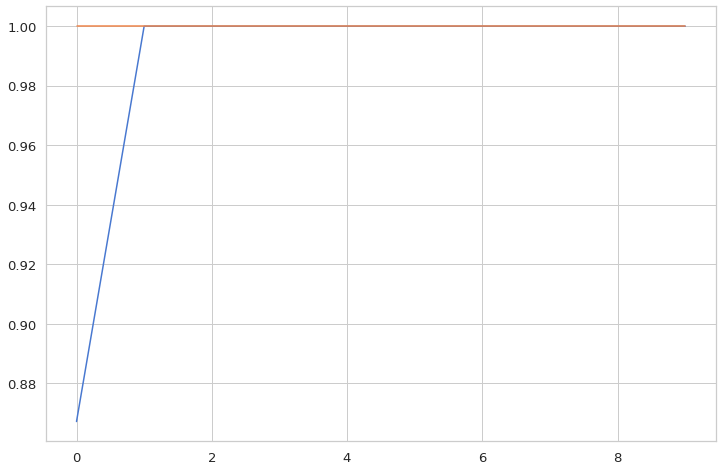

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

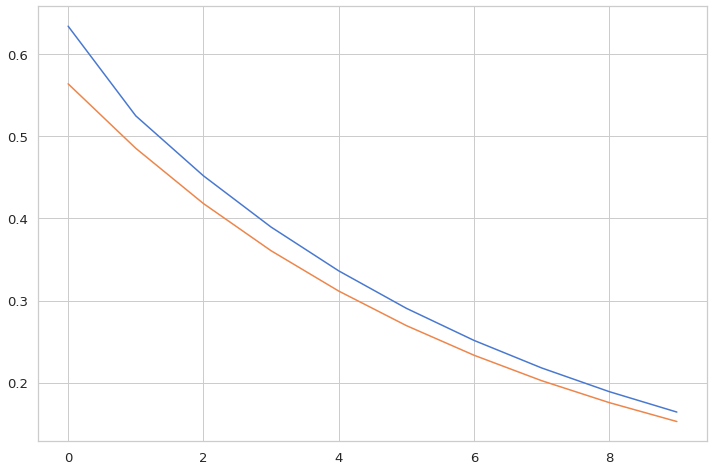

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])